In [8]:
from ete3 import Tree
from Bio import Phylo
from io import StringIO
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
import seaborn as sns

In [ ]:
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm

In [3]:
def branching_factor(tree):
    bf = []
    for i in tree.get_nonterminals():
        bf.append(len(i.clades))
    bf = np.array(bf)
    return bf[bf>1]

In [49]:
def allel_edit_distance(al1, al2):
    n = len(al1)
    diff, cnt = 0, 0
    for i in range(n):
        if (al1[i] == '_') or (al2[i] == '_'):
            continue
        cnt += 1
        if al1[i] != al2[i]:
            if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
                diff += 1
            else:
                diff += 2
    return diff / cnt           

def phylogenetic_distance(tree, node1, node2):
    return tree.distance(node1, node2)



In [4]:
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'

In [127]:
crispr_tree_chan = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'
for i in [1,2,3,6]:
    with open(data_path+f'trees/embryo{i}_all.newick', 'r') as f:
        tree_nwk = f.readline()
    t = Tree(tree_nwk)
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    crispr_tree_chan['terminal'].append(len(tree.get_terminals()))
    crispr_tree_chan['nonterminal'].append(len(tree.get_nonterminals()))
    crispr_tree_chan['branching_factor'].append(branching_factor(tree).mean())
    p_dist, ae_dist = [], []
    em = i
    if em == 2:
        alleletab = pd.read_csv(data_path + f'GSM{3302825+em}_embryo{em}a_alleleTable.txt', sep='\t', index_col=0)
        alleletab1 = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}b_alleleTable.txt', sep='\t', index_col=0)
    else:
        if em >= 3:
            alleletab = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0)
        else:                                          
            alleletab = pd.read_csv(data_path + f'GSM{3302825+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0)

    for _ in tqdm(range(1000)):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        try:
            al1 = alleletab.loc[f'{c1.name}-1']
        except:
            al1 = alleletab1.loc[f'{c1.name}-1']
        try:
            al2 = alleletab.loc[f'{c2.name}-1']
        except:
            al2 = alleletab1.loc[f'{c2.name}-1']
            
        
        if len(al1.shape) == 1:
            al1 = pd.DataFrame(al1).T
        if len(al2.shape) == 1:
            al2 = pd.DataFrame(al2).T
        intbc = set(al1['intBC']).intersection(set(al2['intBC']))
        all1 = ''
        all2 = ''
        for ibc in intbc:
            all1 += str(al1[al1['intBC']==ibc]['allele1'])
            all2 += str(al2[al2['intBC']==ibc]['allele1']) 
        ae_dist.append(allel_edit_distance(all1.split('_'), all2.split('_')))
    crispr_tree_chan['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    crispr_tree_chan['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

100%|██████████| 1000/1000 [00:51<00:00, 19.37it/s]


In [177]:
crispr_tree_yang = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/data3/wangkun/phylovelo_datasets/KPTracer-Data/trees/'
trees = os.listdir(data_path)
trees = [i for i in trees if (i[-5:]=='e.nwk')]

for i in tqdm(trees):
    with open(data_path+i, 'r') as f:
        tree_nwk = f.readline()
    t = Tree(tree_nwk)
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    n_nt = 0
    for j in tree.get_nonterminals():
        if len(j.clades) > 1:
            n_nt += 1
    crispr_tree_yang['terminal'].append(len(tree.get_terminals()))
    crispr_tree_yang['nonterminal'].append(n_nt)
    crispr_tree_yang['branching_factor'].append(branching_factor(tree).mean())
    charater_mat = pd.read_csv(data_path+i.replace('_tree.nwk', '_character_matrix.txt'), sep='\t', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(charater_mat.loc[c1.name], charater_mat.loc[c2.name]))
    crispr_tree_yang['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    crispr_tree_yang['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

100%|██████████| 85/85 [07:16<00:00,  5.14s/it]


In [147]:
smtree = pd.read_csv('/data2/kantian/LineageTracing/SMALT/0.Results/figures/3.1.CRC_Apc_stats.txt', sep='\t')
# smtree = smtree[smtree['sampleType']=='IBD_T']

In [167]:
smalt_tree = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
# smalt_tree_poly = {'terminal':[], 'nonterminal':[], 'branching_factor':[]}
data_path = '/data2/kantian/LineageTracing/SMALT/0.Results/2.final_phy_re/'
# trees = os.listdir(data_path)
# trees = [i for i in trees if (i[-5:]=='e.nwk') and ('T' in i.split('_')[1])]
for i in tqdm(smtree['sample']):
    with open(data_path+f'{i}_filtered_re_rescale.nwk', 'r') as f:
        tree_nwk = f.readline()
    cls = tree_nwk.split(':0.00000)')
    for j, cl in enumerate(cls[:-1]):
        success = 0
        jj = j
        while not success:
            try:
                k = -cls[jj][::-1].index('(')
                new = cls[jj][:k-1] + cls[jj][k:]
                assert ')' not in cls[jj][k:]
                cls[jj] = new
                success = 1
            except:
                jj -= 1
        assert success == 1
    t = Tree(''.join(cls))
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    smalt_tree['terminal'].append(len(tree.get_terminals()))
    smalt_tree['nonterminal'].append(len(tree.get_nonterminals()))
    smalt_tree['branching_factor'].append(branching_factor(tree).mean())
    alltab = pd.read_csv(data_path+f'{i}_filtered_re.phy', sep=' ', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(alltab.loc[c1.name].iloc[0], alltab.loc[c2.name].iloc[0]))
    smalt_tree['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    smalt_tree['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])
    # if '_'.join(i.split('_')[:2]) in mono:
    #     smalt_tree_mono['terminal'].append(len(tree.get_terminals()))
    #     smalt_tree_mono['nonterminal'].append(len(tree.get_nonterminals()))
    #     smalt_tree_mono['branching_factor'].append(branching_factor(tree).mean())
    # else:
    #     smalt_tree_poly['terminal'].append(len(tree.get_terminals()))
    #     smalt_tree_poly['nonterminal'].append(len(tree.get_nonterminals()))
    #     smalt_tree_poly['branching_factor'].append(branching_factor(tree).mean())

100%|██████████| 77/77 [12:24<00:00,  9.67s/it]


In [ ]:
smalt_tree

In [169]:
pd.concat((smtree['sample'],pd.DataFrame(smalt_tree)), axis=1).to_csv('smalt_tree.csv')

In [30]:
pd.DataFrame(smalt_tree)

,terminal,nonterminal,branching_factor
0,776,648,2.195988
1,661,620,2.064516
2,2285,2043,2.117964
3,1228,1073,2.143523
4,1043,912,2.142544
...,...,...,...
72,464,447,2.035794
73,1267,1137,2.113456
74,1314,1207,2.087821
75,3650,3445,2.059216


[Text(0, 0, 'Crispr tree\n(Chan 2019)'),
 Text(1, 0, 'Crispr tree\n(Yang 2022)'),
 Text(2, 0, 'SMALT tree')]

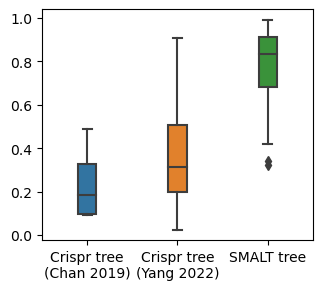

In [24]:
fig, ax = plt.subplots(figsize=(3.5,3))
sns.boxplot([np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']), 
             np.array(crispr_tree_yang['nonterminal'])/np.array(crispr_tree_yang['terminal']),
             np.array(smalt_tree['nonterminal'])/np.array(smalt_tree['terminal']),
            ], width=0.2, ax=ax)
ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'SMALT tree'])

[Text(0, 0, 'Crispr tree\n(Chan 2019)'),
 Text(1, 0, 'Crispr tree\n(Yang 2022)'),
 Text(2, 0, 'SMALT tree')]

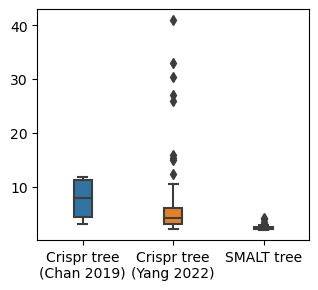

In [25]:
fig, ax = plt.subplots(figsize=(3.5,3))
sns.boxplot([np.array(crispr_tree_chan['branching_factor']),
             np.array(crispr_tree_yang['branching_factor']),
             np.array(smalt_tree['branching_factor']),
            ], width=0.2, ax=ax)
ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'SMALT tree'])

In [140]:
branching_factor(tree).mean()

2.1596548004314995

In [170]:
pd.DataFrame(crispr_tree_chan).to_csv('crispr_tree_chan.csv')

In [179]:
pd.DataFrame(crispr_tree_yang).to_csv('crispr_tree_yang.csv')

In [26]:
pd.DataFrame(smalt_tree).to_csv('smalt_tree.csv')